In [1]:
from numpy import *
# from matplotlib.pyplot import *
# import os
# ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals


def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = mean(eigVals, axis=0)

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of diverse structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge


def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [269]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 4:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif len(region) == 3:  
            region = find_cross_points(region, crossovers, values)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign

        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 15):
            updateRegions.append(currReg)
    
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge



In [254]:
averageEigVects.shape

(1104, 1087)

In [259]:
try_vals = averageEigVects[:,1]

In [260]:
oneModeHinge_update(try_vals)

([[80, 79, 77, 76],
  [83, 84],
  [160, 161],
  [179, 177, 178, 180],
  [189, 190],
  [320, 321],
  [325, 326],
  [342, 343],
  [359, 360],
  [399, 400],
  [500, 501],
  [632, 629, 628, 631, 630, 633],
  [634, 635],
  [712, 713],
  [730, 732, 731, 729],
  [741, 742],
  [871, 872],
  [877, 878],
  [894, 895],
  [911, 912],
  [951, 952],
  [1052, 1053]],
 [0.00013788708905165014,
  0.0006661352864709162,
  -0.0003362230654364154,
  -0.0006670854825662005,
  0.00021825659716820638,
  -0.0017258318670191337,
  -0.0019031346961353298,
  0.0014289262855921314,
  0.0056858441400175486,
  0.006376523099134694,
  -0.0009041620411241207,
  -0.005849335303751759,
  -0.005718176943752822,
  1.7822225688047193e-05,
  0.0004650134375783733,
  -0.004304006384573988,
  -0.0034616596163238728,
  0.0009582915918710502,
  0.0015991028899096536,
  -0.0015182045308645246,
  -0.000684108589503661,
  0.0014327981793559046,
  0.003041843977382808,
  -0.002894086560048284,
  -0.0022849992034111102,
  0.0011862

In [257]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total


import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids_diverse.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [4]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

# Method 3

In [5]:
def trimEnds(values, lists, Number):
    begining = Number
    ends = len(values) - Number
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions


In [6]:
def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

In [7]:
# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

In [8]:
def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    if crossoverPoints_pairs == []:
        return []
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs


In [218]:
def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 4:
            # print ('region, crossovers, values', region, crossovers)
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - len(currRegion)) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        # elif 3 <= len(region) == 4:
            # region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [219]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    
    # trim Regions
    # trimmedFinal = trimRegions(Final, values)
    trimmedFinal = Final
    
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 10):
            updateRegions.append(currReg)
    
    # print ('update region is', updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [11]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
    # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [210]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]], trimmingLength = 20):
    FilteringIndex = []
    # trimmingLength = 15
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

# COX2

In [13]:
currPDB = '4m11'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_A, averageEigVects_A, ids_A, gnms_A, averageEigVects_A = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Submitted Dali search for PDB "4m11A".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//4m11A/
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> Dali results were fetched in 76.0s.                          
@> Obtained 440 PDB chains from Dali for 4m11A.
@> 402 PDBs have been filtered out from 440 Dali hits (remaining: 38).
@> Retrieving 4m11A... [  0%]

# of similar structures is found from Dali 38


@> 38 PDBs were parsed in 12.82s.
@> Mapping 1ebvA_ca to the reference... [ 23%] 2s@> WARNING 
the number of residues in the map_dict (551 residues) is inconsistent with Chain A from 1ebvA_ca (550 residues)
@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 8.9266e-01
@> Step #2: RMSD difference = 8.7313e-06
@> Iterative superposition completed in 0.02s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.01 seconds.
@> Ensemble (37 conformations) were built in 1.50s.
@> WARNING 1 structures cannot be mapped.
@> WARNING last 1 modes for 550 modes from MaskedGNM 4m11A_ca reduced has been discarded because at least one conformation has only 550 modes
@> all GNM modes were calculated for each of the 37 conformations in 5.92s.
@> 550 modes across 37 modesets were matched in 2.35s.


In [14]:
currPDB = '4m11'
eachChain = 'B'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_B, averageEigVects_B, ids_B, gnms_B, averageEigVects_B = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Submitted Dali search for PDB "4m11B".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//4m11B//
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> Dali results were fetched in 116.5s.                         
@> Obtained 434 PDB chains from Dali for 4m11B.
@> 414 PDBs have been filtered out from 434 Dali hits (remaining: 20).
@> Retrieving 4m11B... [  0%]

# of similar structures is found from Dali 20


@> 20 PDBs were parsed in 6.34s. 
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 8.6443e-01
@> Step #2: RMSD difference = 9.7262e-06
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.01 seconds.
@> Ensemble (20 conformations) were built in 0.74s.
@> WARNING last 1 modes for 550 modes from MaskedGNM 4m11B_ca reduced has been discarded because at least one conformation has only 550 modes
@> all GNM modes were calculated for each of the 20 conformations in 3.52s.
@> 550 modes across 20 modesets were matched in 1.17s.


In [209]:
mergeIDs_all = []

for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4]:
            if item[:4] not in mergeIDs_all:
                mergeIDs_all.append(item[:4])

print (len(mergeIDs_all))

18


In [16]:
mergeIDs = []

for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4] and item[-1] != each[-1]:
            if item[:4] not in mergeIDs:
                mergeIDs.append(item[:4])
mergeIDs

['4m11', '1ht8', '1ht5', '3n8v', '7jxt', '3n8y', '3n8w', '3n8x', '3kk6']

In [72]:
len(mergeIDs)

9

In [17]:
ags = parsePDB(mergeIDs, subset='ca', chain='A B')
dali_ens = buildPDBEnsemble(ags)
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = gnms.getEigvals()[0]
eigVects = gnms.getEigvecs()
averageEigVecs = mean(eigVects, axis=0)

@> 9 PDBs were parsed in 3.35s.   
@> Starting iterative superposition:                
@> Step #1: RMSD difference = 8.6165e-01
@> Step #2: RMSD difference = 4.0310e-04
@> Step #3: RMSD difference = 2.6038e-06
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (9 conformations) were built in 26.78s.
@> WARNING last 16 modes for 1087 modes from MaskedGNM 4m11A B_ca reduced has been discarded because at least one conformation has only 1087 modes
@> all GNM modes were calculated for each of the 9 conformations in 4.80s.
@> 1087 modes across 9 modesets were matched in 1.62s.


In [123]:
bindings = ['57', '81', '84', '85', '88', '160', '173', '174', '307', '312', '313', '316', '317', '318', '320', '321', '322', '323', '324', '327', '328', '349', '352', '353', '354', '355', '356', '481', '484', '485', '486', '487', '490', '491', '492', '494', '495', '496', '498', '499', '500', '502', '609', '633', '636', '637', '640', '712', '725', '726', '859', '864', '865', '868', '869', '870', '872', '873', '874', '875', '876', '879', '880', '901', '904', '905', '906', '907', '908', '1033', '1036', '1037', '1038', '1039', '1042', '1043', '1044', '1046', '1047', '1048', '1050', '1051', '1052', '1054']

bindings = ['57', '80', '81', '83', '84', '85', '87', '88', '89', '160', '172', '173', '174', '195', '196', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '326', '327', '328', '346', '348', '349', '350', '351', '352', '353', '354', '355', '356', '358', '481', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '506']

bindings = ['57', '81', '84', '85', '88', '173', '312', '313', '316', '317', '320', '321', '322', '323', '327', '349', '352', '353', '355', '484', '485', '486', '487', '490', '491', '492', '494', '495', '496', '498', '499', '502', '609', '633', '636', '637', '640', '725', '864', '865', '868', '869', '872', '873', '874', '875', '879', '901', '904', '905', '907', '1036', '1037', '1038', '1039', '1042', '1043', '1044', '1046', '1047', '1048', '1050', '1051', '1054']

bindings = [x for x in bindings]

binding = list(set([int(x) for x in bindings]))

binding = [57,60,81,84,85,88,160,173,174,177,195,196,312,313,316,317,319,320,321,322,323,327,343,345,349,352,353,355,481,484,485,486,487,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,609,612,633,636,637,640,712,725,726,729,747,748,864,865,868,869,871,872,873,874,875,879,895,897,901,904,905,907,1033,1036,1037,1038,1039,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1053,1054,1055]


In [124]:
sort(binding)

array([  57,   60,   81,   84,   85,   88,  160,  173,  174,  177,  195,
        196,  312,  313,  316,  317,  319,  320,  321,  322,  323,  327,
        343,  345,  349,  352,  353,  355,  481,  484,  485,  486,  487,
        490,  491,  492,  493,  494,  495,  496,  497,  498,  499,  500,
        501,  502,  503,  504,  609,  612,  633,  636,  637,  640,  712,
        725,  726,  729,  747,  748,  864,  865,  868,  869,  871,  872,
        873,  874,  875,  879,  895,  897,  901,  904,  905,  907, 1033,
       1036, 1037, 1038, 1039, 1042, 1043, 1044, 1045, 1046, 1047, 1048,
       1049, 1050, 1051, 1053, 1054, 1055])

In [125]:
averageEigVals = mean(eigVals, axis=0)

In [126]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

4

In [127]:
averageEigVects = averageEigVecs

In [128]:
averageEigVects.shape

(1104, 1087)

In [158]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [159]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 550], [551, 1104]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 550], [551, 1104]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 550], [551, 1104]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 550], [551, 1104]])

In [160]:
protein_length = 1104

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 94
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 131 18 0.02146624749945447
# of hinge sites for first 3 modes, overlap, hyper score 79 14 0.004726470049821074
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 166 24 0.003739293596357496
# of hinge sites for first 3 modes, overlap, hyper score 104 19 0.0006098538167674805


In [132]:
ubi = parsePDB('4m11', subset='calpha')
calphas = ubi.select('calpha and chain A B')
gnm = GNM('COX')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge3 = calcHinges(gnm[3])
Hinge4 = calcHinges(gnm[4])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 4m11 downloaded (4m11.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> Secondary structures were assigned to 1364 residues.
@> Kirchhoff was built in 0.05s.
@> 1103 modes were calculated in 0.44s.


In [133]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 94
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 213 28 0.0069112199818393005
# of hinge sites for 3 modes, overlap, hyper score 139 19 0.019084335092591997
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 240 32 0.0027113101166306164
# of hinge sites for 3 modes, overlap, hyper score 158 22 0.009119035140037313


## writeResults

In [161]:
averageEigVects.shape

(1104, 1087)

In [162]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

1104

In [163]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [164]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [165]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 550], [551, 1104]])
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [166]:
curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
writeAllData('./Data/COX2_Method1.txt', curr)

## Method 2

In [298]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)


In [299]:
Hinges_2 = filterTwoEnds(Hinges_2, [[0, 550], [551, 1103]], 20)
Hinges_3 = filterTwoEnds(Hinges_3, [[0, 550], [551, 1103]], 20)
Hinges_4 = filterTwoEnds(Hinges_4, [[0, 550], [551, 1103]], 20)
Hinges_5 = filterTwoEnds(Hinges_5, [[0, 550], [551, 1103]], 20)

In [300]:
protein_length = 1104

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 94
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 180 30 6.404467058873653e-05
# of hinge sites for first 3 modes, overlap, hyper score 115 25 2.391849683869296e-06
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 185 30 0.000111696623762092
# of hinge sites for first 3 modes, overlap, hyper score 118 25 4.008272419753212e-06


In [301]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 94
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 212 33 0.00010359120042469083
# of hinge sites for 3 modes, overlap, hyper score 154 30 2.128927468647568e-06
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 217 33 0.00017045769010903822
# of hinge sites for 3 modes, overlap, hyper score 156 30 2.862910854384282e-06


In [302]:
AverageEigVals1 = gnms.getEigvals()[0]
AverageEigVals2 = mean(gnms.getEigvals(), axis=0)
proteinLength = 1104
Segment = int(proteinLength / 5)
print ('mark Index are', 0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1)

mark Index are 0 220 440 660 880 1103


In [303]:
Labels = ['A:33', 'A:252', 'A:472', 'B:140', 'B:360', 'B:583']
SplitLabel = 551

In [304]:
currHinge = Hinges_5

# of hinges 118
# of bindings sites 94
# of hits are 25


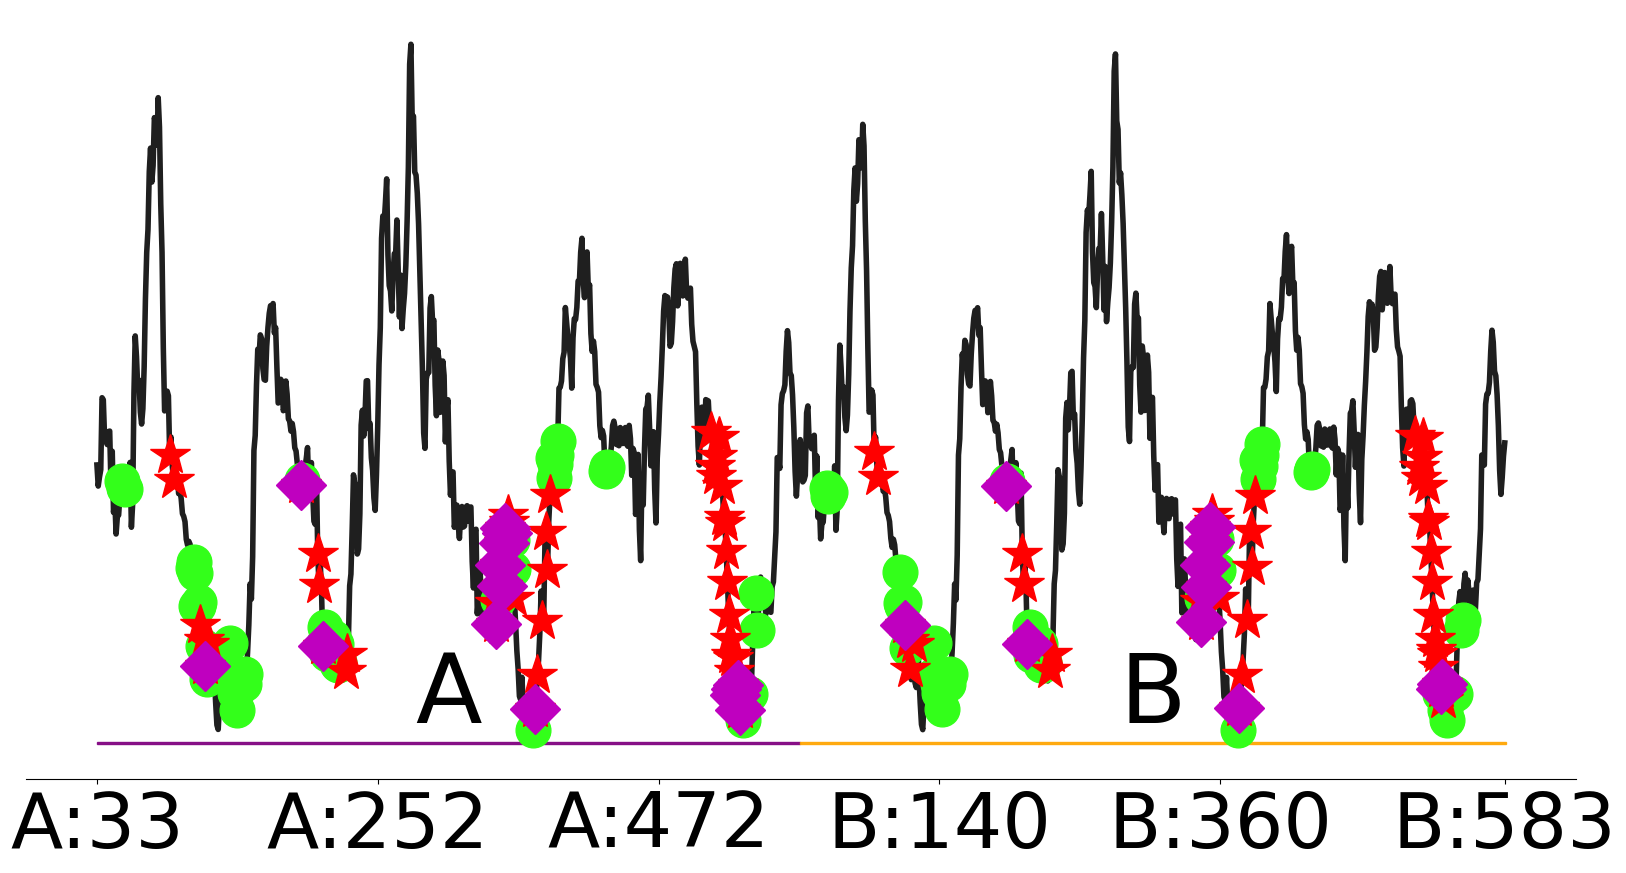

In [310]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
plt.sca(ax)  # Set current axis to 'ax'
    
# Increase font sizes
plt.rc('xtick', labelsize=55)
plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 70})

# calcMSF
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / AverageEigVals1[mode]
    MSF.append(currMSF)

plt.plot(MSF, color='black', linewidth=4, alpha=0.88)    

HingeY = [MSF[item] for item in currHinge]
plt.plot(currHinge, HingeY, color=(0.2, 1, 0.1), marker='o', linestyle='', markersize=25)
print ('# of hinges', len(HingeY))

# plot binding sites
bindingY = [MSF[item] for item in binding]
plt.plot(binding, bindingY, 'r*', markersize=30)
print ('# of bindings sites', len(binding))

# plot overlaps
allHinge = currHinge
overlaps = [item for item in binding if item in allHinge]
overlapsY = [MSF[item] for item in overlaps]
plt.plot(overlaps, overlapsY, 'mD', markersize=25)

print ('# of hits are', len(overlaps))

# Hide y labels
plt.gca().yaxis.set_visible(False)

# Hide top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
y = MSF
# Determine the lower y-limit for bands and labels
lower_y_limit = min(y) * 0.01
upper_y_limit = min(y) * 0.4

# Add narrow bands below the plot
ax.add_patch(patches.Rectangle((0, lower_y_limit), SplitLabel, upper_y_limit - lower_y_limit, color='purple', alpha=0.9))
ax.add_patch(patches.Rectangle((SplitLabel, lower_y_limit), proteinLength - SplitLabel, upper_y_limit - lower_y_limit, color='orange',alpha=0.9))
# Add labels just above the bands
ax.text(SplitLabel / 2, upper_y_limit, 'A', color='black', ha='center', va='bottom')
ax.text((SplitLabel + proteinLength) / 2, upper_y_limit, 'B', color='black', ha='center', va='bottom')

# Set x-axis labels and title with Arial font
# plt.title('Cyclooxygenase 2')
plt.xticks([0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1], Labels)

plt.savefig('./COX2_MSF.png', dpi=500)

In [311]:
AverageEigVals1

sdarray([ 0.23367432,  0.44918671,  0.7053199 , ..., 31.42221691,
         31.57763446, 31.60897687])

## write data

In [274]:
# write MSFs
# averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

1104

In [275]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [276]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 550], [551, 1104]])
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [277]:
writeAllData('./Data/COX2_Method2_update.txt', curr)

# method 3

In [73]:
averageEigVects.shape

(1104, 1087)

In [175]:
ubi = parsePDB('4m11', subset='calpha') # 1udu
calphas = ubi.select('calpha and chain A B')
gnm = GNM('PDE')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge2 = calcHinges(gnm[3])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 4m11 downloaded (4m11.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> Secondary structures were assigned to 1364 residues.
@> Kirchhoff was built in 0.05s.
@> 1103 modes were calculated in 0.40s.


In [196]:
Hinges_2 = getHinges3(averageEigVects,currNumModes, [Hinge0, Hinge1, Hinge2, Hinge3], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1, Hinge2, Hinge3], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [197]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 550], [551, 1104]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 550], [551, 1104]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 550], [551, 1104]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 550], [551, 1104]])

In [193]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [[], [], [], []], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [[], [], []], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [[], [], [], []], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [[], [], []], 15)

In [194]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 550], [551, 1103]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 550], [551, 1103]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 550], [551, 1103]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 550], [551, 1103]])

In [198]:
protein_length = 1104

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 94
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 192 29 0.0005774325653291612
# of hinge sites for first 3 modes, overlap, hyper score 125 23 0.00012648353362865183
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 203 29 0.0015354806362113393
# of hinge sites for first 3 modes, overlap, hyper score 129 23 0.0002115732456918762


## writeResults

In [182]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)

In [183]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [186]:
row, col = averageEigVects.shape

Hinges_calc = [Hinge0, Hinge1, Hinge2]
i = 0
for mode in modes:
    currHinge = getHinges_modes3(averageEigVects, mode, Hinges_calc[i], bandWidth=15)
    i += 1
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 550], [551, 1104]])
    currList = sort(list(set(list(currHinge))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [187]:
writeAllData('./Data/COX2_Method3.txt', curr)

# Write Modes

In [36]:
def writeModesAsBfactors(mode, eigenVects):
    residue = []
    new_b_factor = []
    chain = 'A'

    resiIndex = 4
    for item in eigenVects[:, mode]:
        resiIndex += 1
        residue.append(resiIndex)
        new_b_factor.append(item)

    with open('./Structure_demo/ALB_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
        for i in range(len(residue)):
            wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [37]:
writeModesAsBfactors(0, eigenVects)
writeModesAsBfactors(1, eigenVects)

# Plot graphs

In [188]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [295]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3, chain=False)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    
    currHinge = filterTwoEnds(currHinge, [[0, 550], [551, 1103]], 20)
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', [x for x in (currHinge)], len(currHinge))
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    # Set x-ticks
    # Setting custom tick labels on the x-axis
    # plt.xticks([0, 200, 400, 600],['A:537', 'A:748', 'B:624', 'B:835'])
    
    plt.tight_layout()
    plt.savefig('./COX2_method2Merging_trim20_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [512, 656, 657, 659, 660, 21, 22, 1063, 1064, 573, 574, 104, 105, 107, 108, 511] 16
local loop motion []
current bindings are [57, 60, 81, 84, 85, 88, 160, 173, 174, 177, 195, 196, 312, 313, 316, 317, 319, 320, 321, 322, 323, 327, 343, 345, 349, 352, 353, 355, 481, 484, 485, 486, 487, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 609, 612, 633, 636, 637, 640, 712, 725, 726, 729, 747, 748, 864, 865, 868, 869, 871, 872, 873, 874, 875, 879, 895, 897, 901, 904, 905, 907, 1033, 1036, 1037, 1038, 1039, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1053, 1054, 1055]
current hits are []
# of overlaps finding from current mode is 0


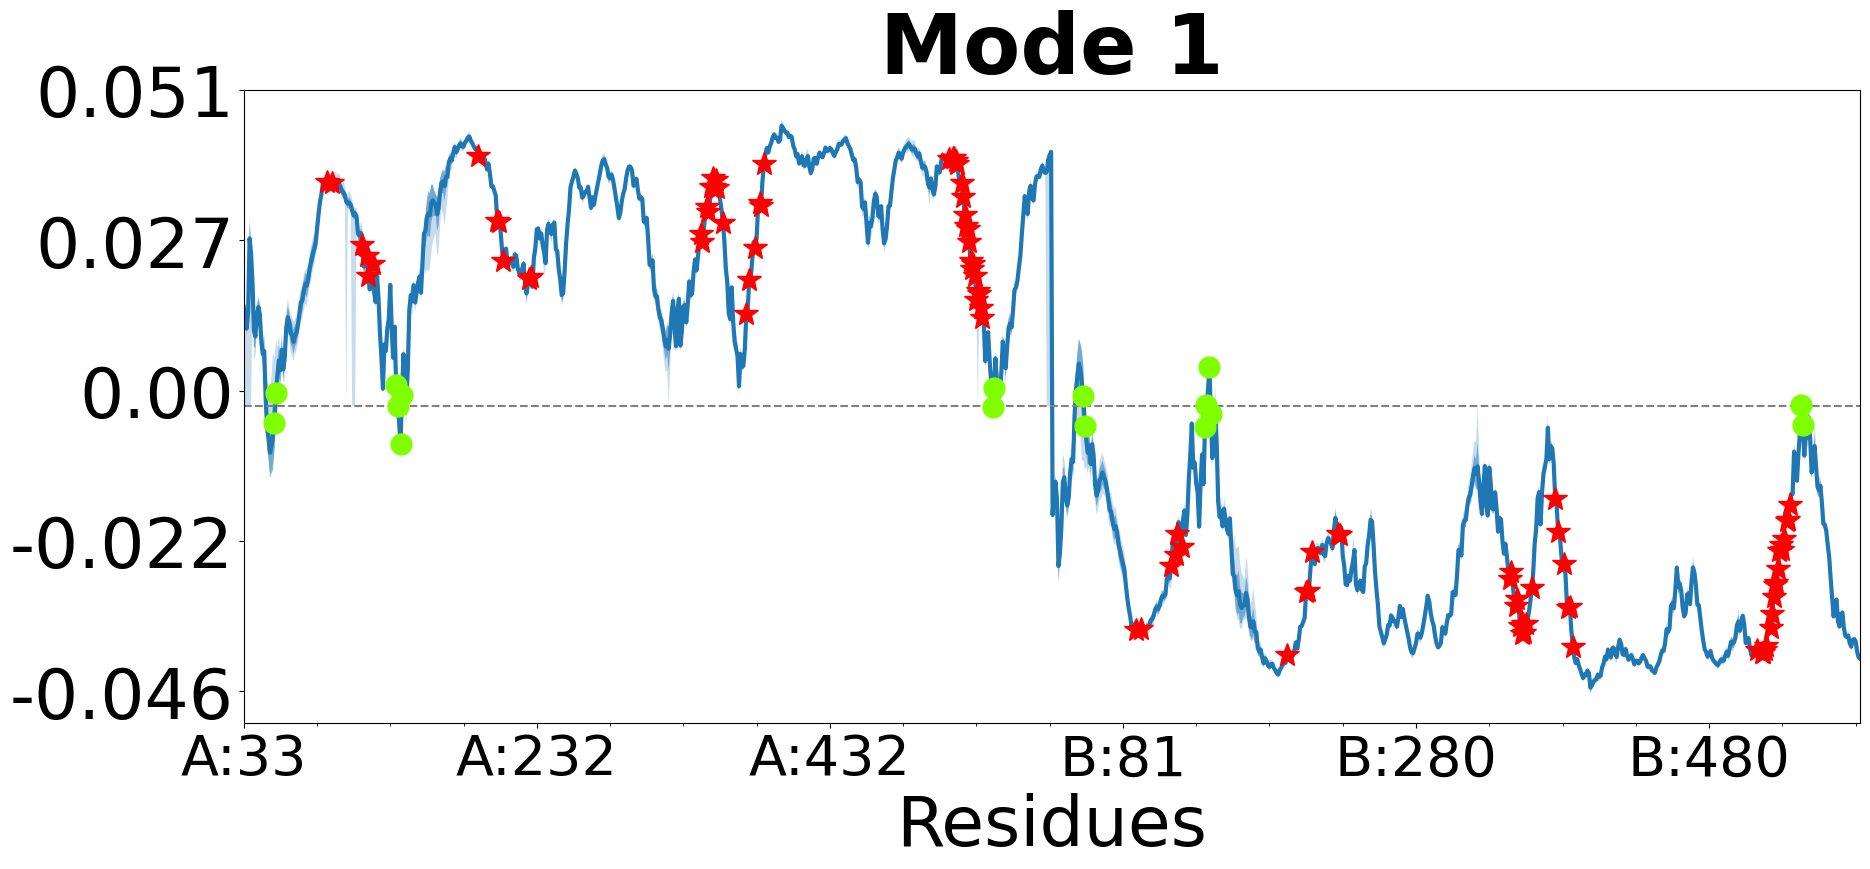

In [296]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [910, 399, 400, 911, 913, 912, 1052, 1053, 160, 161, 177, 178, 179, 180, 951, 952, 189, 190, 320, 321, 325, 326, 712, 713, 75, 76, 77, 78, 79, 80, 83, 85, 86, 342, 343, 729, 730, 731, 732, 741, 358, 359, 360, 361, 742, 871, 872, 877, 878, 633, 500, 501, 629, 631, 632, 630, 635, 894, 895] 59
local loop motion []
current bindings are [57, 60, 81, 84, 85, 88, 160, 173, 174, 177, 195, 196, 312, 313, 316, 317, 319, 320, 321, 322, 323, 327, 343, 345, 349, 352, 353, 355, 481, 484, 485, 486, 487, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 609, 612, 633, 636, 637, 640, 712, 725, 726, 729, 747, 748, 864, 865, 868, 869, 871, 872, 873, 874, 875, 879, 895, 897, 901, 904, 905, 907, 1033, 1036, 1037, 1038, 1039, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1053, 1054, 1055]
current hits are [85, 160, 177, 320, 321, 343, 500, 501, 633, 712, 729, 871, 872, 895, 1053]
# of overlaps finding from current mode is 15


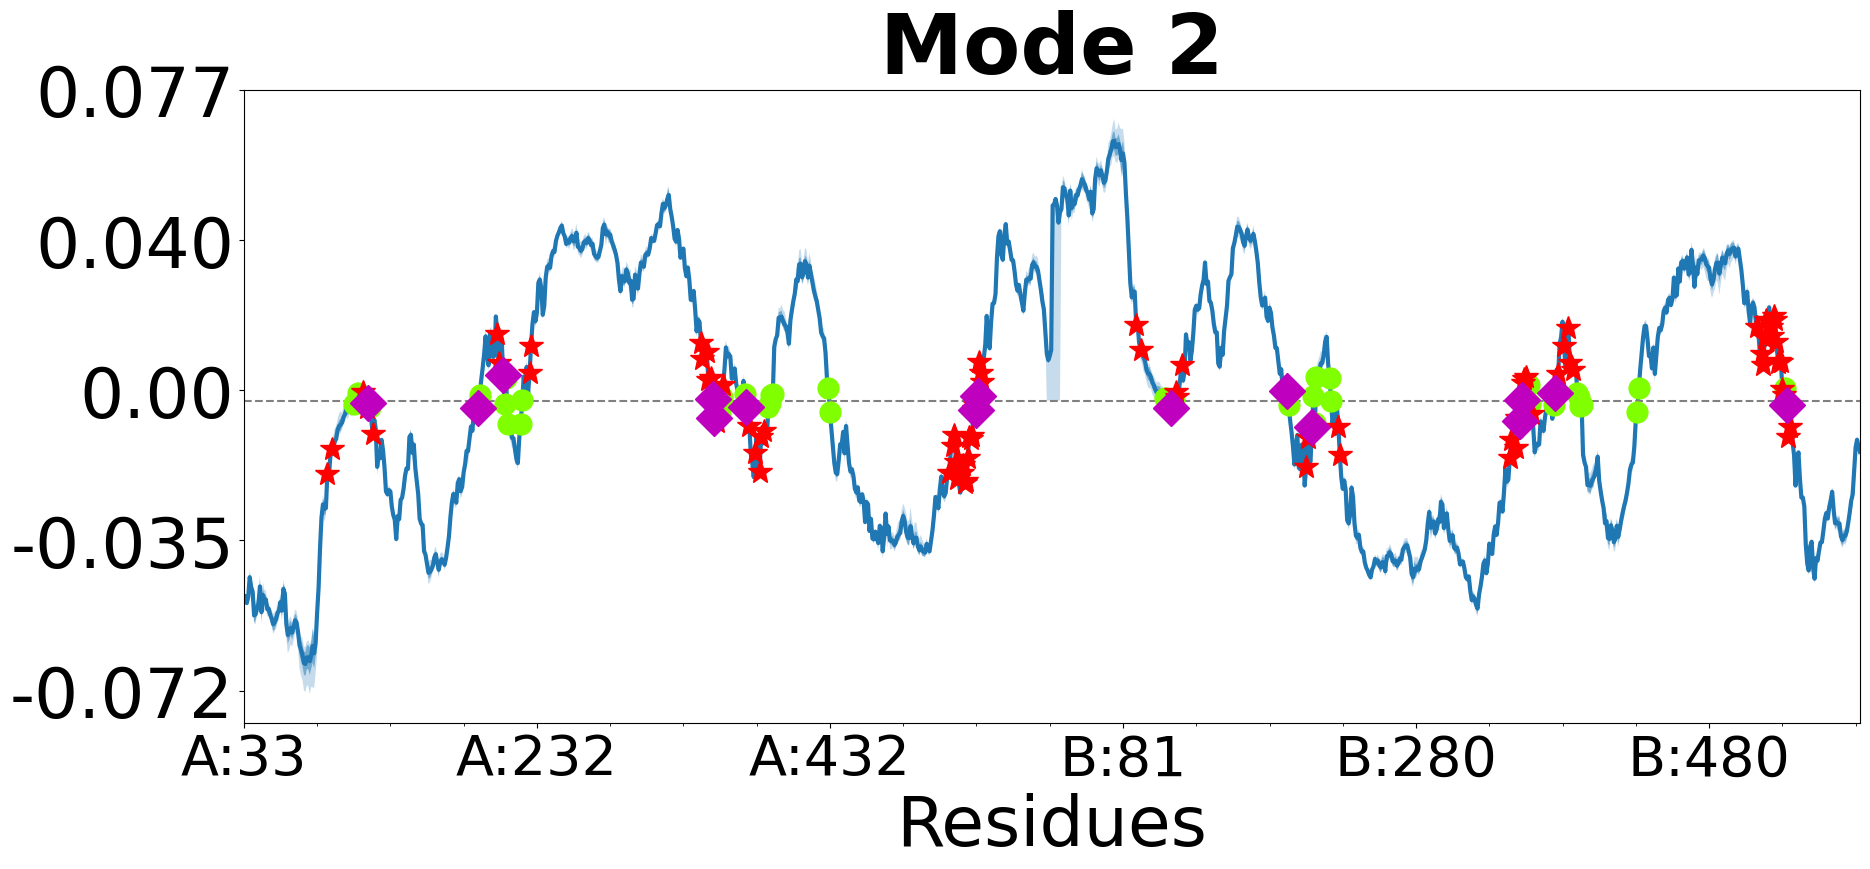

In [297]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [516, 517, 909, 910, 399, 400, 656, 20, 21, 657, 661, 662, 667, 668, 1053, 1054, 160, 161, 1057, 1059, 1058, 1056, 1069, 1070, 952, 951, 184, 313, 185, 314, 316, 187, 188, 317, 319, 320, 572, 573, 712, 713, 736, 737, 865, 739, 740, 357, 358, 866, 104, 105, 868, 869, 109, 110, 115, 116, 501, 502, 504, 505, 506, 507] 62
local loop motion []
current bindings are [57, 60, 81, 84, 85, 88, 160, 173, 174, 177, 195, 196, 312, 313, 316, 317, 319, 320, 321, 322, 323, 327, 343, 345, 349, 352, 353, 355, 481, 484, 485, 486, 487, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 609, 612, 633, 636, 637, 640, 712, 725, 726, 729, 747, 748, 864, 865, 868, 869, 871, 872, 873, 874, 875, 879, 895, 897, 901, 904, 905, 907, 1033, 1036, 1037, 1038, 1039, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1053, 1054, 1055]
current hits are [160, 313, 316, 317, 319, 320, 501, 502, 504, 712, 865, 868, 869, 1053, 1054]
# of overlaps finding from cur

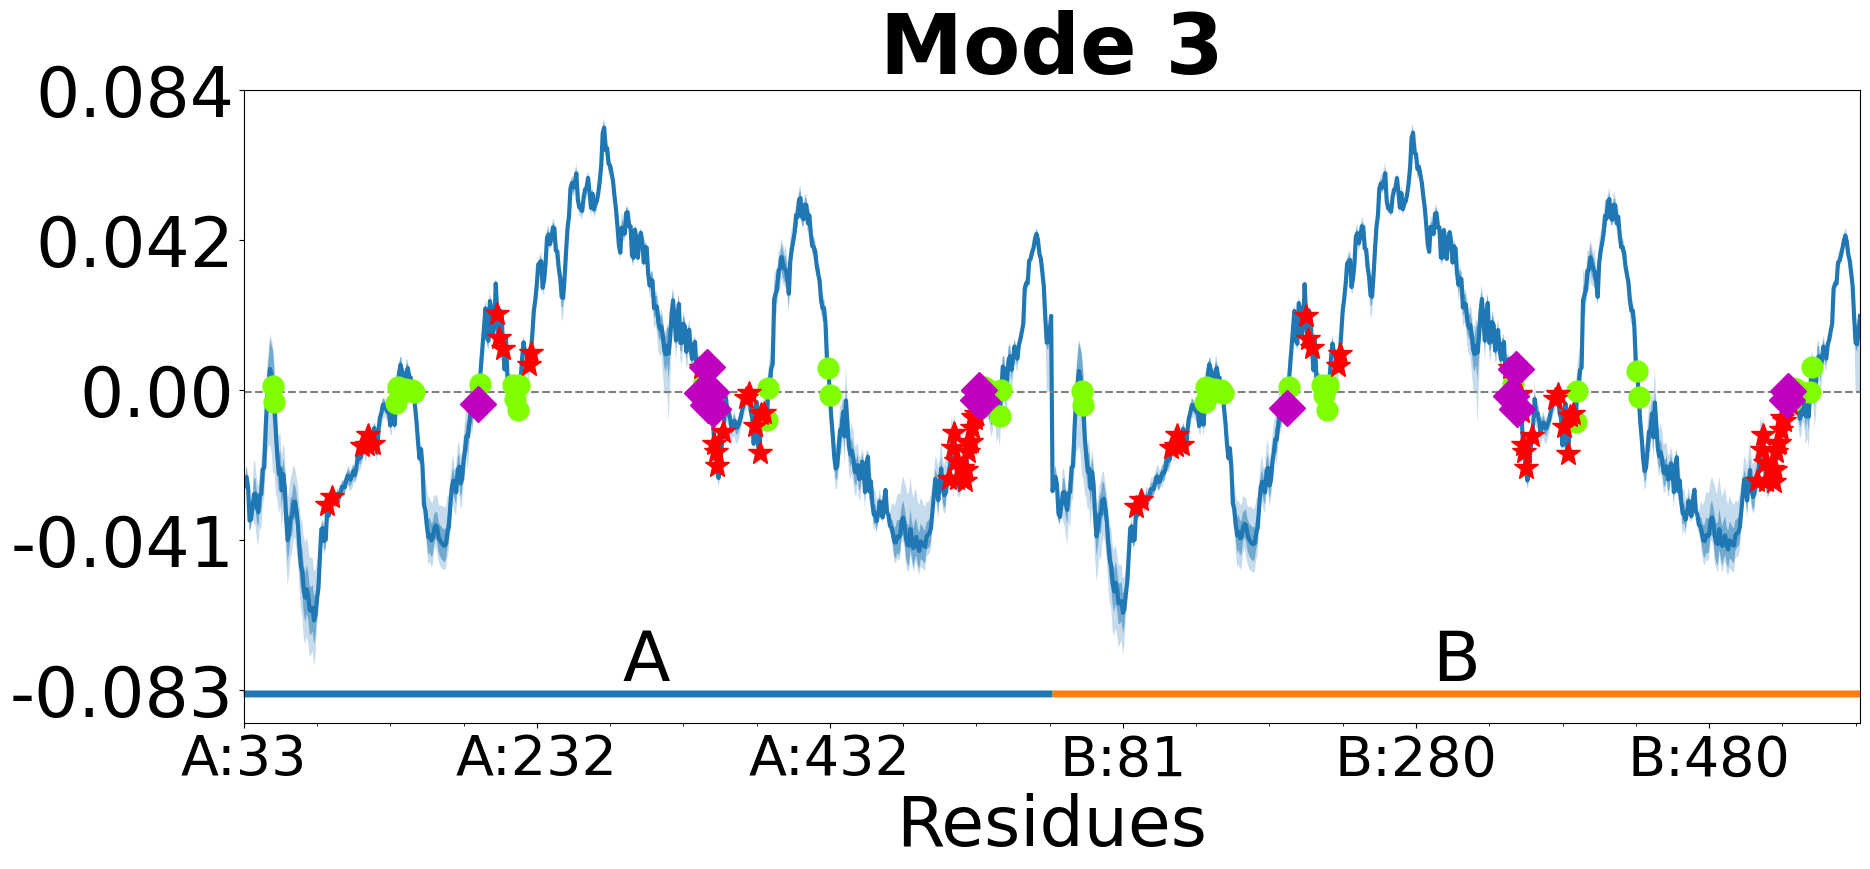

In [294]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

# store data

In [143]:
mode = 3

In [144]:
residue = []
new_b_factor = []

for item in averageEigVecs[:, mode]:
    new_b_factor.append(item)


In [145]:
resiIndex = [x for x in range(33, 583)]
chain = ['A' for x in range(33, 583)]


resiIndex += [x for x in range(33, 583)]
chain += ['B' for x in range(33, 583)]


In [146]:
with open('./structure_demo/COX2_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(resiIndex)):
        # print (chain[i])
        wf.write(chain[i] + ', ' + str(resiIndex[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [142]:
!pwd

/data/frank/Desktop/Hinges_Figures_all/COX2
